In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [30]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               687 non-null    object 
 1   Player             687 non-null    object 
 2   MatchId            687 non-null    object 
 3   Map                687 non-null    object 
 4   Category           687 non-null    object 
 5   Playlist           687 non-null    object 
 6   Input              687 non-null    object 
 7   Queue              687 non-null    object 
 8   PreCsr             687 non-null    int64  
 9   PostCsr            687 non-null    int64  
 10  Rank               687 non-null    int64  
 11  WasAtStart         687 non-null    int64  
 12  WasAtEnd           687 non-null    int64  
 13  WasInProgressJoin  687 non-null    int64  
 14  Mmr                2 non-null      float64
 15  Outcome            687 non-null    object 
 16  Accuracy           687 non

In [31]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               456 non-null    int64         
 1   Date                456 non-null    datetime64[ns]
 2   Map                 456 non-null    object        
 3   Category            456 non-null    object        
 4   Rank                456 non-null    int64         
 5   Outcome             456 non-null    int64         
 6   Accuracy            456 non-null    float64       
 7   DamageDone          456 non-null    int64         
 8   DamageTaken         456 non-null    int64         
 9   ShotsFired          456 non-null    int64         
 10  ShotsLanded         456 non-null    int64         
 11  ShotsMissed         456 non-null    int64         
 12  KD                  456 non-null    float64       
 13  KDA                 456 non-null    float64       

In [32]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,456.0,412.934211,157.093967,140.000000,279.750000,413.500000,546.500000,686.000000
Rank,456.0,3.942982,2.175042,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,456.0,0.541667,0.498808,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,456.0,51.441952,5.468503,24.390000,48.390000,51.560000,54.650000,80.560000
DamageDone,456.0,5155.567982,1832.022117,347.000000,3849.000000,4880.500000,6352.500000,12673.000000
DamageTaken,456.0,4420.673246,1522.564514,276.000000,3428.750000,4212.000000,5338.000000,9962.000000
ShotsFired,456.0,234.605263,79.620459,16.000000,180.750000,224.000000,291.000000,517.000000
ShotsLanded,456.0,120.438596,42.255015,4.000000,93.000000,113.000000,148.000000,286.000000
ShotsMissed,456.0,114.166667,40.810022,7.000000,86.000000,110.500000,141.000000,261.000000
KD,456.0,1.251579,0.673054,0.000000,0.860000,1.130000,1.440000,6.000000


In [33]:
print("Kills           ", dfr.Kills.sum())
print("Expected Kills  ", round(dfr.ExpectedKills.sum(),))
print("Deaths          ", dfr.Deaths.sum())
print("Expected Deaths ", round(dfr.ExpectedDeaths.sum(),))
print("KD              ", round(dfr.Kills.sum() / dfr.Deaths.sum(),2))
print("Excepcted KD    ", round(dfr.ExpectedKills.sum() / dfr.ExpectedDeaths.sum(),2))


Kills            6633
Expected Kills   6547
Deaths           5856
Expected Deaths  6493
KD               1.13
Excepcted KD     1.01


In [34]:
dfr.tail()

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
451,682,2024-02-06 05:29:51,Live Fire,Oddball,2,1,51.65,4450,4323,182,...,1.109889,1.156217,49.693050,29.041850,10.330396,50.143172,6.982379,3.502203,867,0.539823
452,683,2024-02-06 05:42:15,Recharge,King of the Hill,8,0,47.72,4937,3497,241,...,1.110256,1.156541,49.690572,29.022325,10.326625,50.170461,6.983394,3.497196,860,0.538631
453,684,2024-02-06 05:53:58,Recharge,Oddball,4,1,46.43,5114,4015,252,...,1.110705,1.156711,49.686300,29.023052,10.340285,50.175631,6.970362,3.490670,872,0.539648
454,685,2024-02-06 06:06:48,Forbidden,CTF 3 Captures,3,1,52.11,1399,1464,71,...,1.110515,1.156605,49.687195,29.021286,10.335747,50.175554,6.967303,3.500110,877,0.540659
455,686,2024-02-06 06:13:33,Live Fire,Strongholds,1,1,61.39,5649,3449,202,...,1.112288,1.157204,49.699461,29.004708,10.336144,50.180664,6.985656,3.492828,890,0.541667


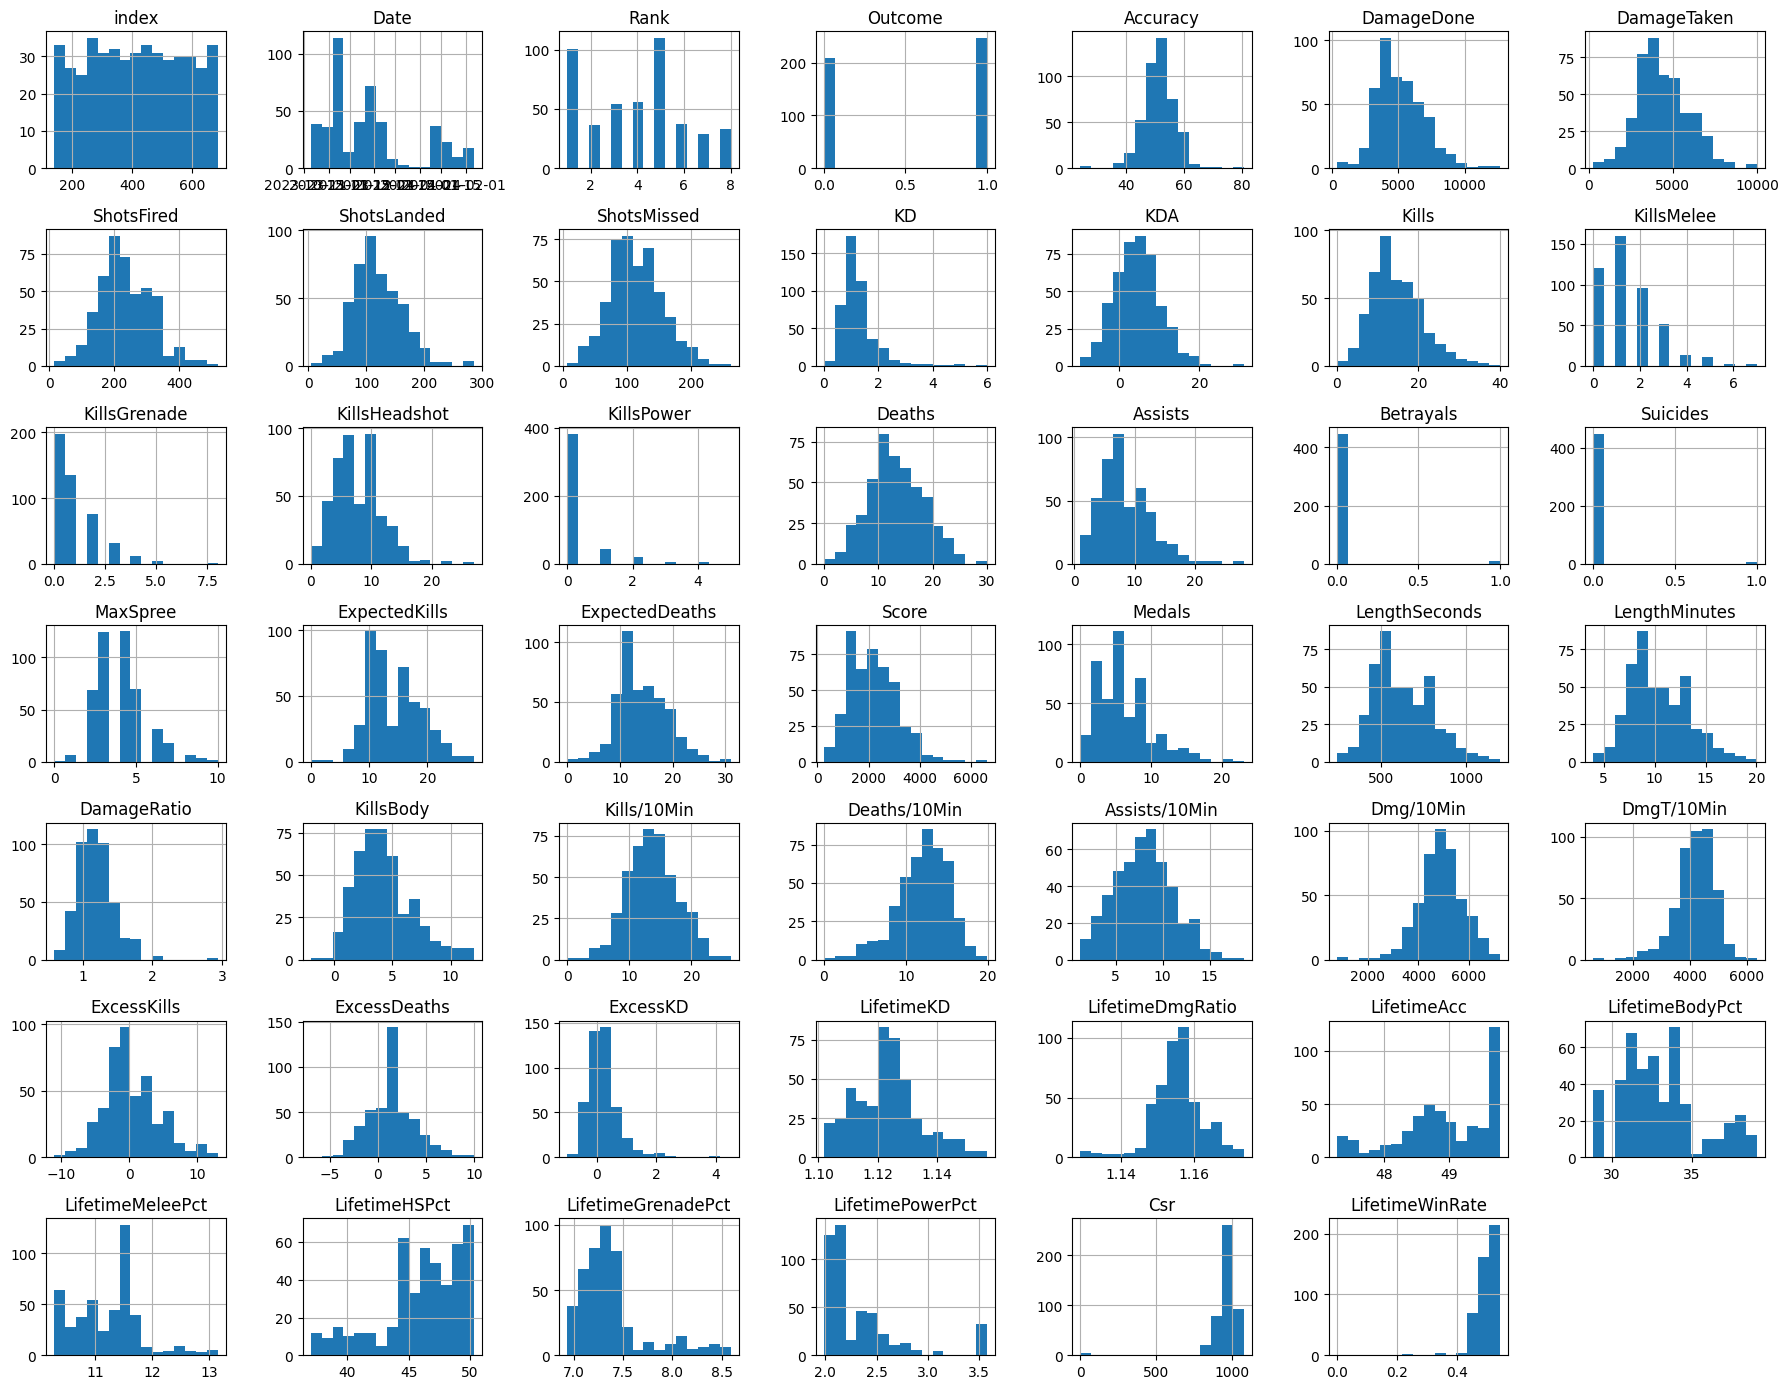

In [35]:
dfr.hist(bins=15, figsize=(18, 14))
plt.tight_layout()
plt.show()

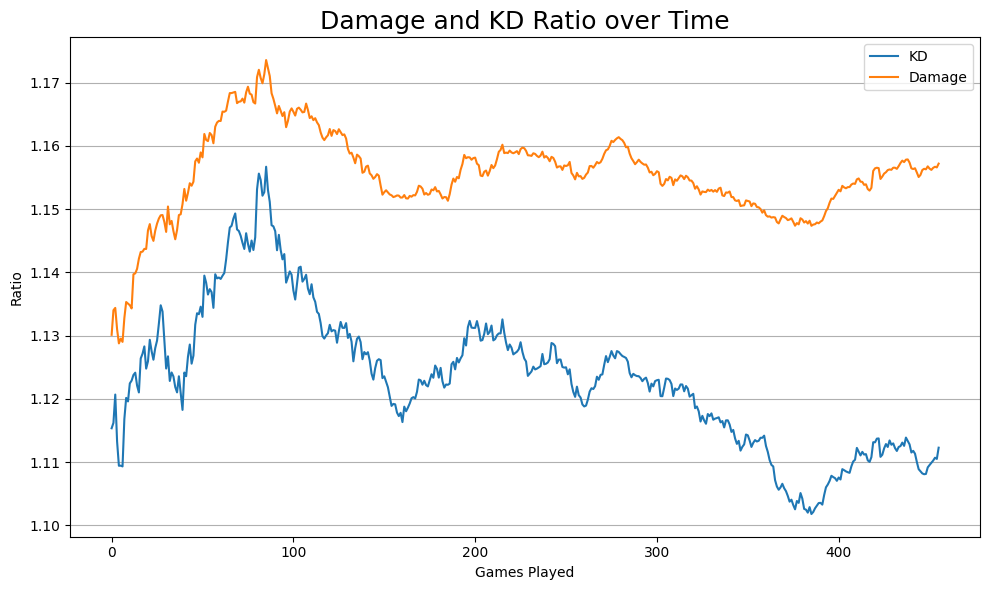

In [36]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

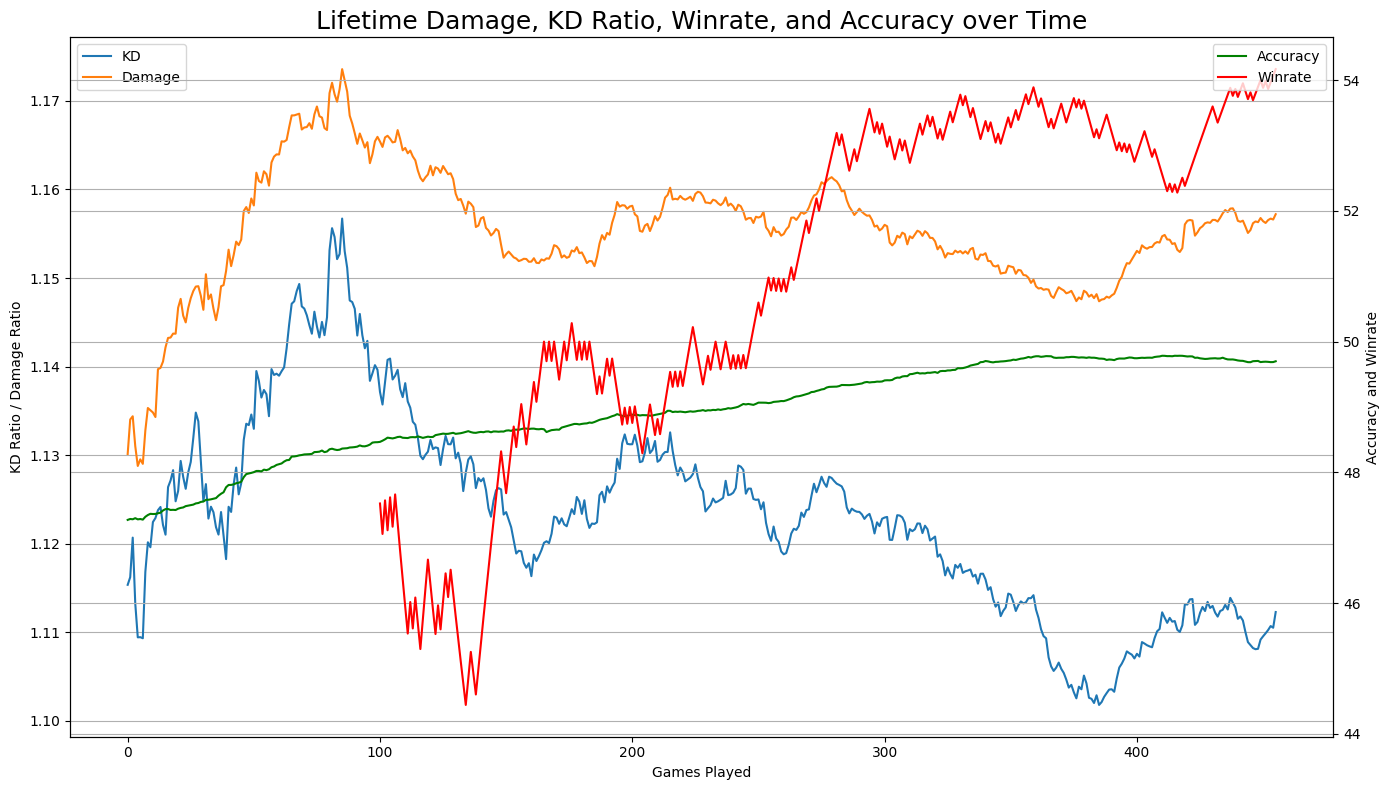

In [37]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='red', label='Winrate')
ax1.set_title('Lifetime Damage, KD Ratio, Winrate, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

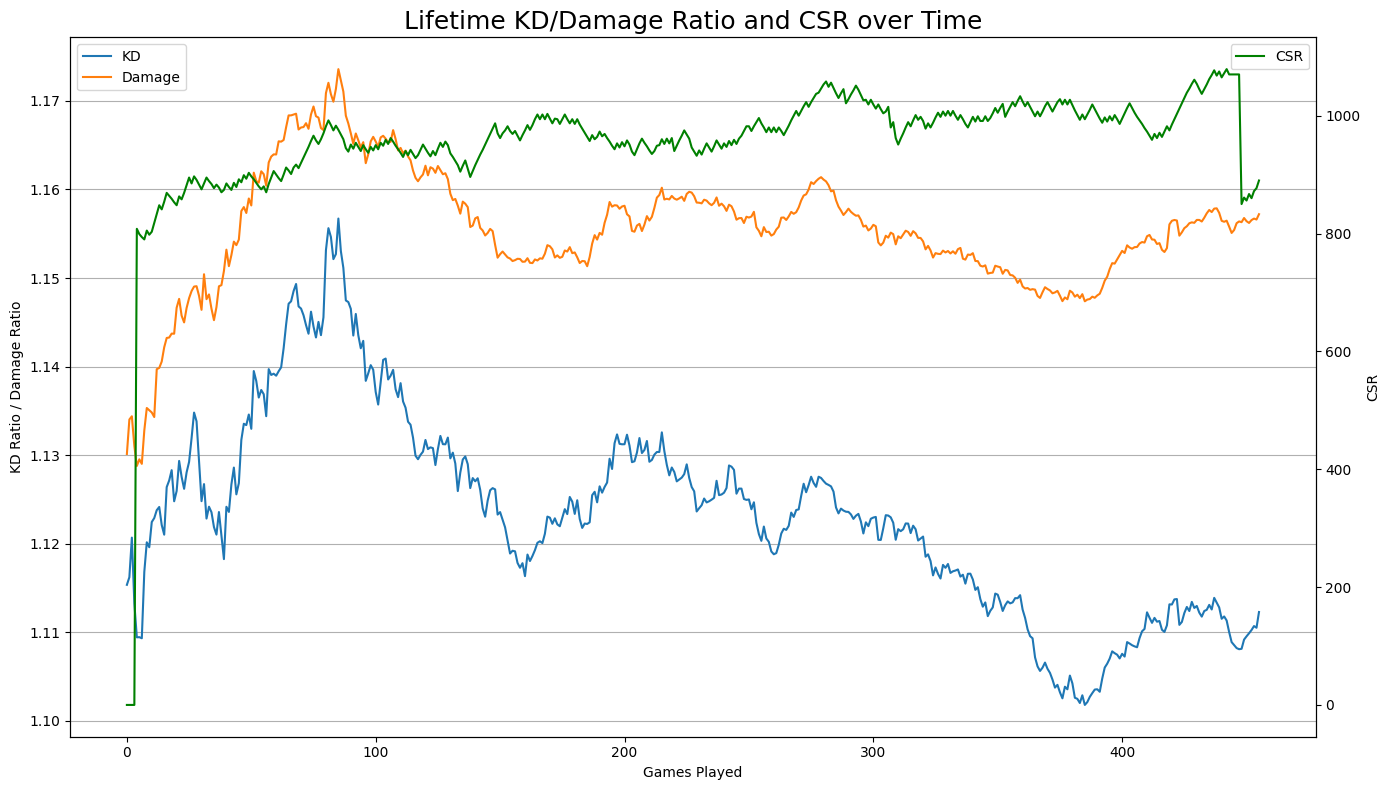

In [38]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

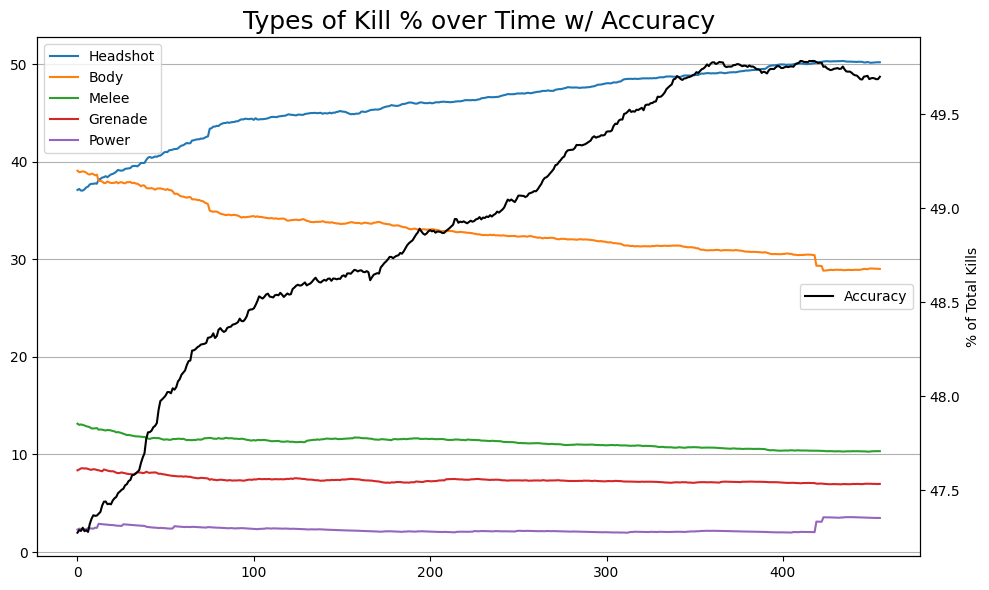

In [39]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Types of Kill % over Time w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

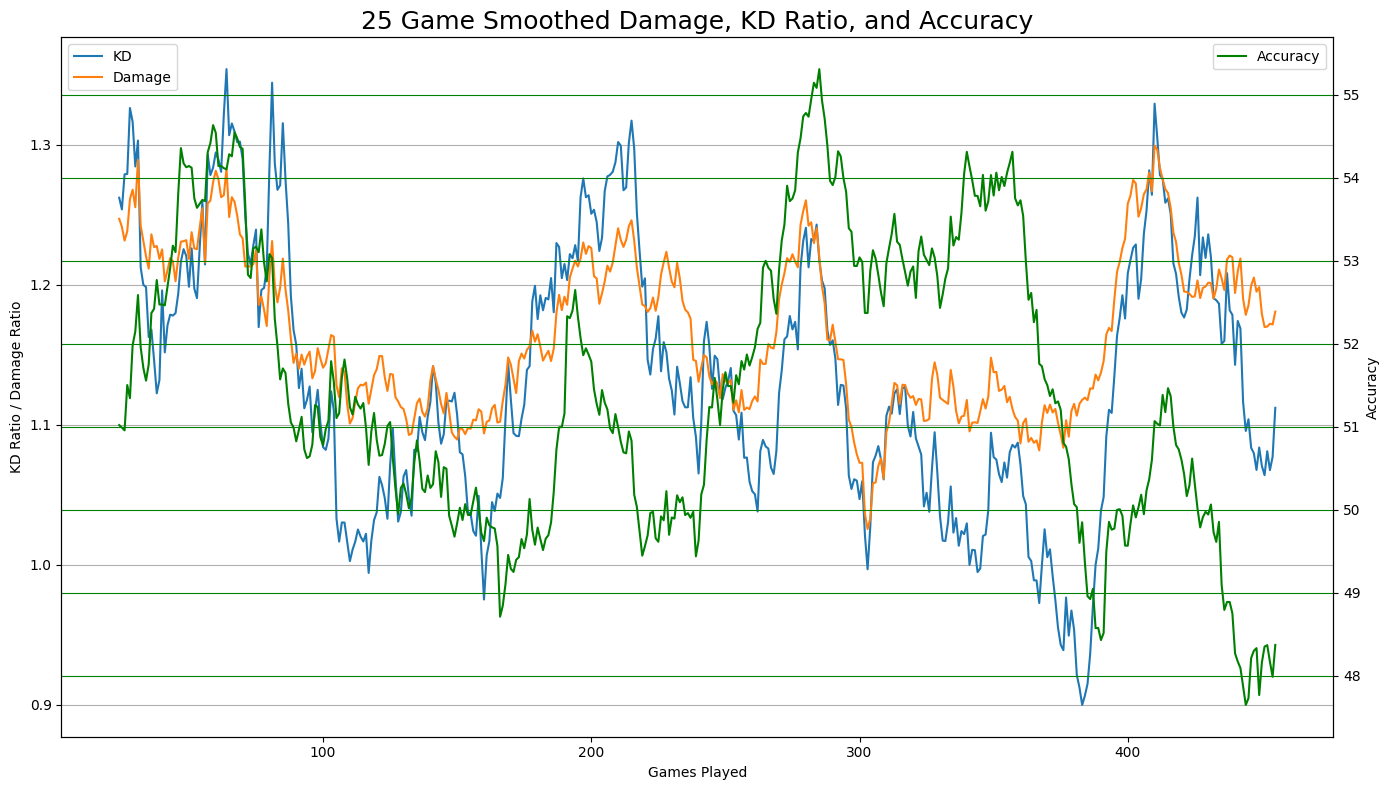

In [40]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedAccuracy'] = dfr['ShotsLanded'].rolling(window=roll).sum() / dfr['ShotsFired'].rolling(window=roll).sum() * 100
dfr['SmoothedDmgRatio'] = dfr['DamageDone'].rolling(window=roll).sum() / dfr['DamageTaken'].rolling(window=roll).sum()
dfr['SmoothedKD'] = dfr['Kills'].rolling(window=roll).sum() / dfr['Deaths'].rolling(window=roll).sum()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedKD'], label='KD' )
ax1.plot(dfr['SmoothedDmgRatio'], label='Damage')
ax2.plot(dfr['SmoothedAccuracy'], color='green', label='Accuracy')
ax1.set_title(f'{roll} Game Smoothed Damage, KD Ratio, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['Accuracy'].max()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, axis='y')
ax2.grid(True, axis='y', color='green')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAccSmooth.png', dpi=300)
plt.show()

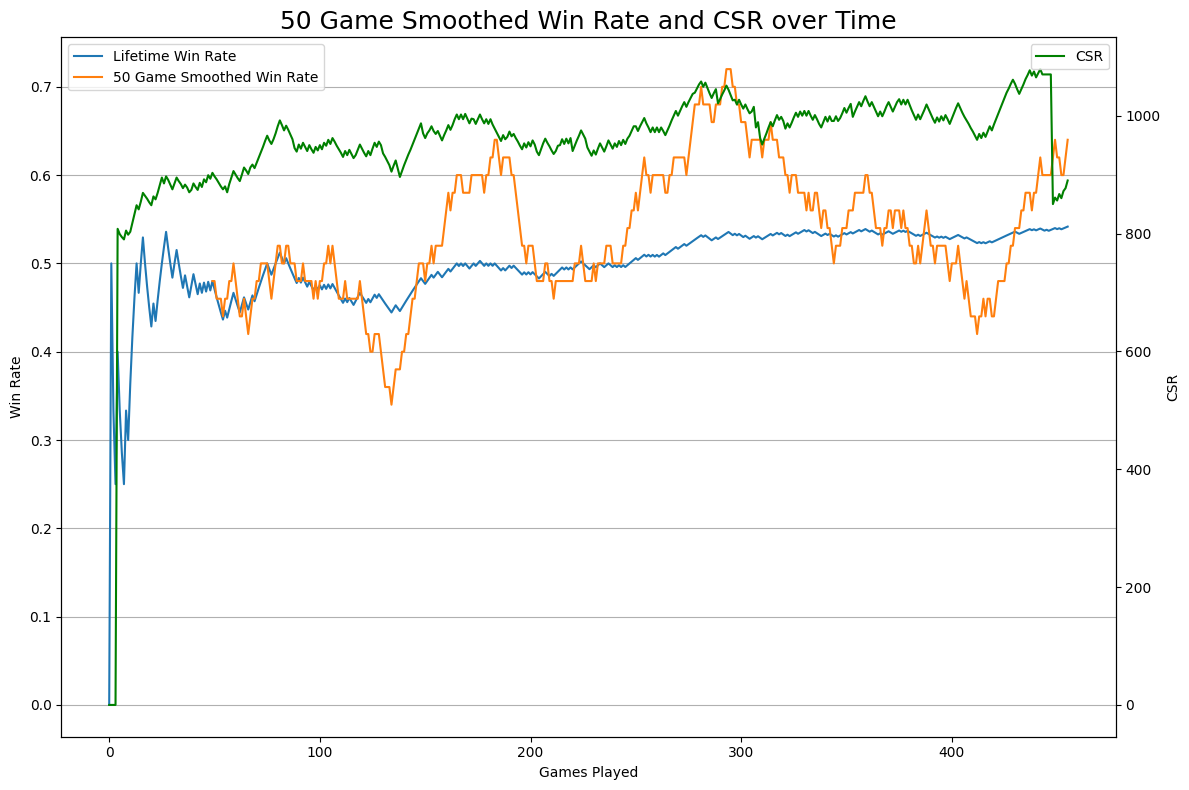

In [41]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()
roll = 50
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeWinRate'], label='Lifetime Win Rate' )
ax1.plot(dfr['SmoothedWinRate'], label=(f'{roll} Game Smoothed Win Rate'))
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title(f'{roll} Game Smoothed Win Rate and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('Win Rate')
ax2.set_ylabel('CSR')
ax1.yaxis.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/WinRateCSR.png', dpi=300)
plt.show()

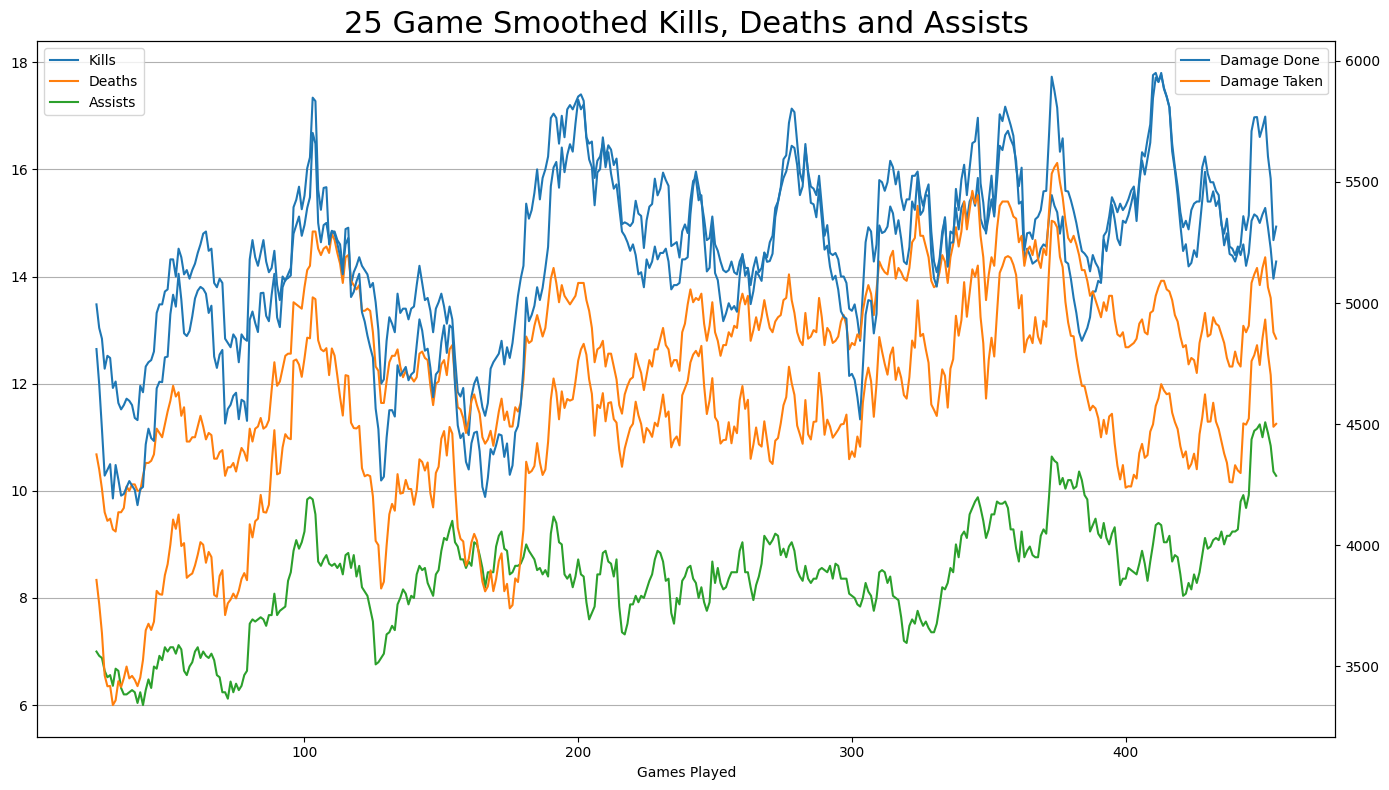

In [42]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedKills'] = dfr['Kills'].rolling(window=roll).mean() 
dfr['SmoothedDeaths'] = dfr['Deaths'].rolling(window=roll).mean() 
dfr['SmoothedAssists'] = dfr['Assists'].rolling(window=roll).mean()
dfr['SmoothedDmg'] = dfr['DamageDone'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DamageTaken'].rolling(window=roll).mean()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax1.plot(dfr['SmoothedKills'], label='Kills' )
ax1.plot(dfr['SmoothedDeaths'], label='Deaths')
ax1.plot(dfr['SmoothedAssists'], label='Assists')
ax2.plot(dfr['SmoothedDmg'], label='Damage Done')
ax2.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.set_title(f'{roll} Game Smoothed Kills, Deaths and Assists', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_facecolor('red')


ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

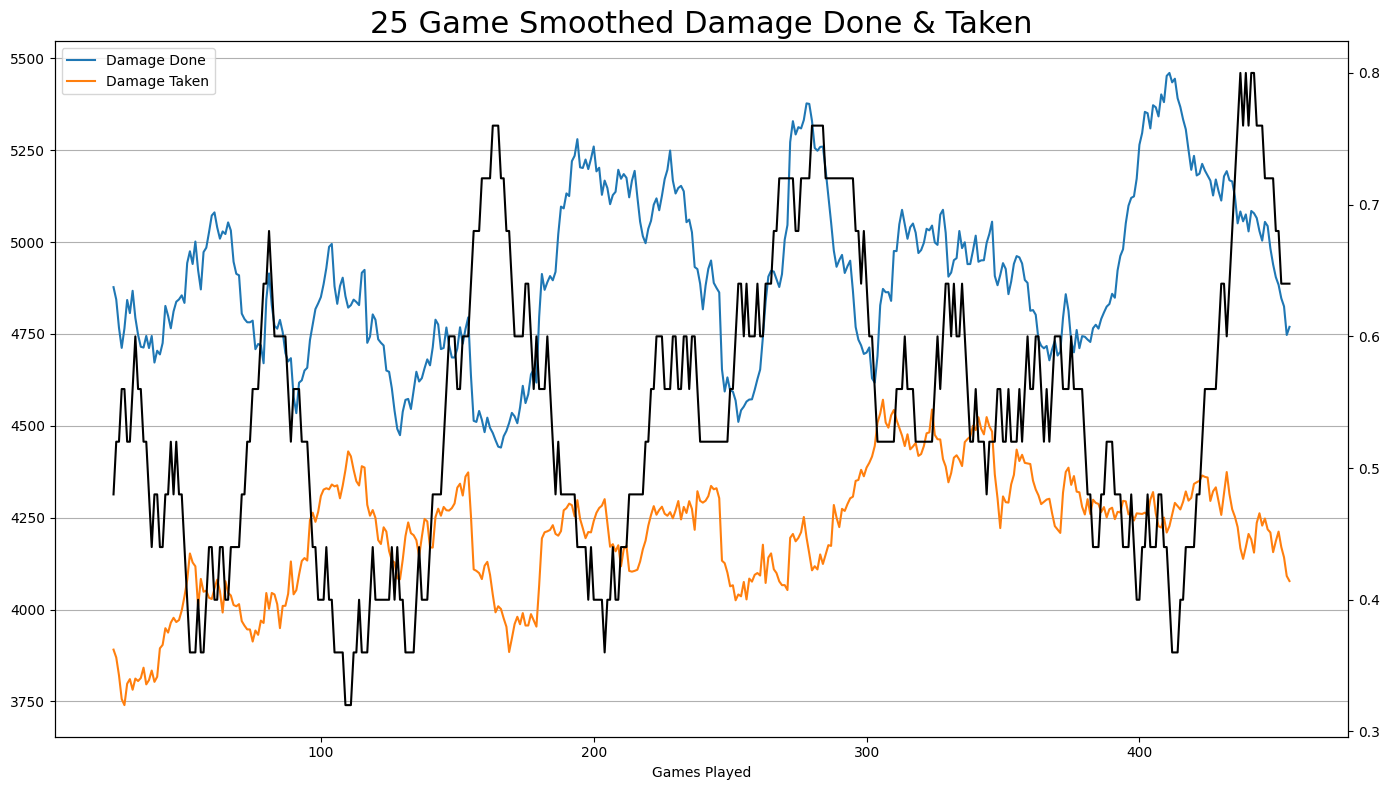

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeWinRate,SmoothedAccuracy,SmoothedDmgRatio,SmoothedKD,SmoothedWinRate,SmoothedKills,SmoothedDeaths,SmoothedAssists,SmoothedDmg,SmoothedDmgT
0,140,2023-10-19 19:49:41,Solitude,King of the Hill,5,0,52.31,7146,4957,325,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141,2023-10-19 20:06:10,Solitude,Strongholds,1,1,50.49,7974,5281,309,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,142,2023-10-19 20:25:03,Recharge,King of the Hill,5,0,46.36,6889,5906,343,...,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,143,2023-10-19 20:42:40,Streets,Extraction,5,0,53.61,3854,4960,194,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144,2023-10-19 20:55:21,Argyle,CTF 3 Captures,3,1,41.56,2769,3501,231,...,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedDmg'] = dfr['Dmg/10Min'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DmgT/10Min'].rolling(window=roll).mean()
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedDmg'], label='Damage Done')
ax1.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax2.plot(dfr['SmoothedWinRate'], label='Winrate', color='black')
ax1.set_title(f'{roll} Game Smoothed Damage Done & Taken', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

dfr.head()

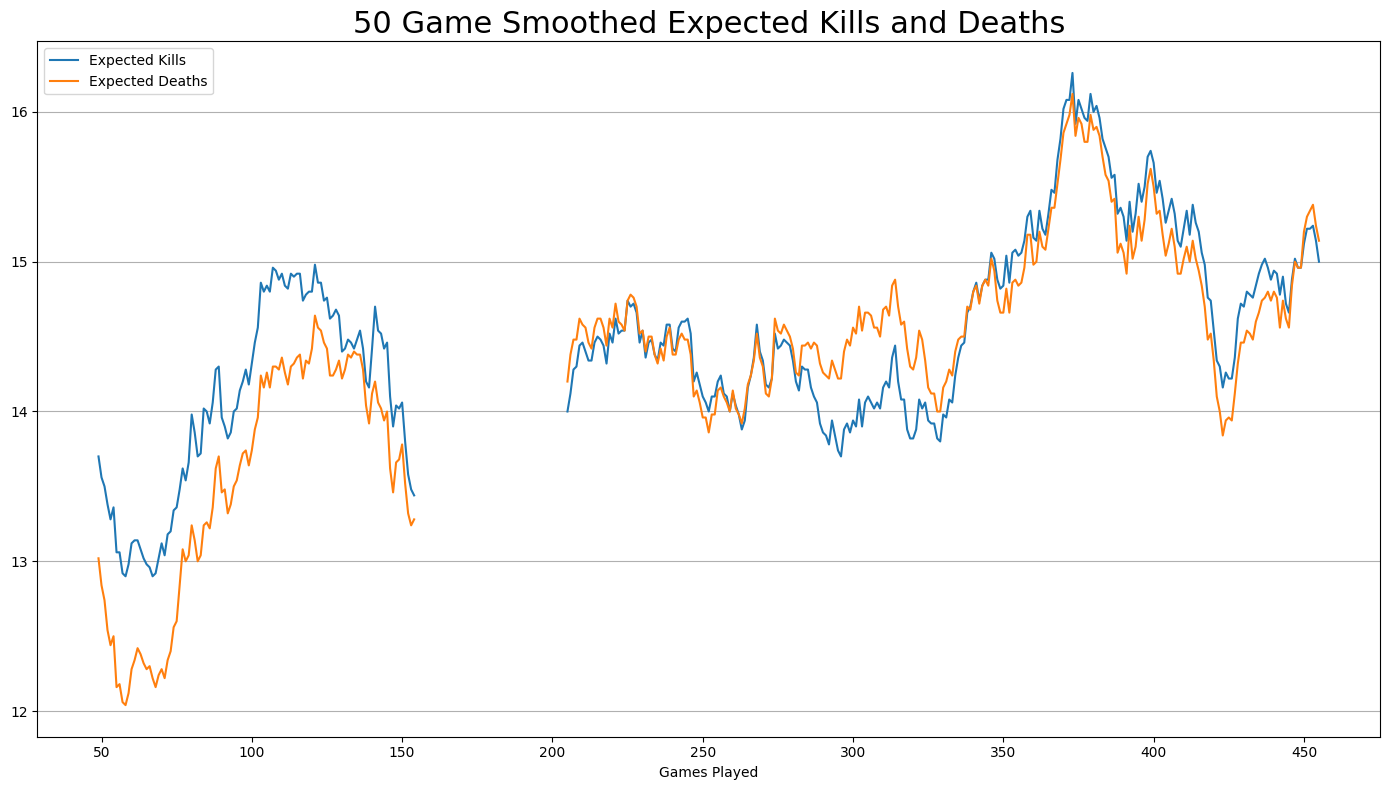

In [44]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 50
dfr['SmoothedExKills'] = dfr['ExpectedKills'].rolling(window=roll).mean()
dfr['SmoothedExDeaths'] = dfr['ExpectedDeaths'].rolling(window=roll).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax1.plot(dfr['SmoothedExKills'], label='Expected Kills')
ax1.plot(dfr['SmoothedExDeaths'], label='Expected Deaths')
ax1.set_title(f'{roll} Game Smoothed Expected Kills and Deaths', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/ExKDSmooth.png', dpi=300)
plt.show()

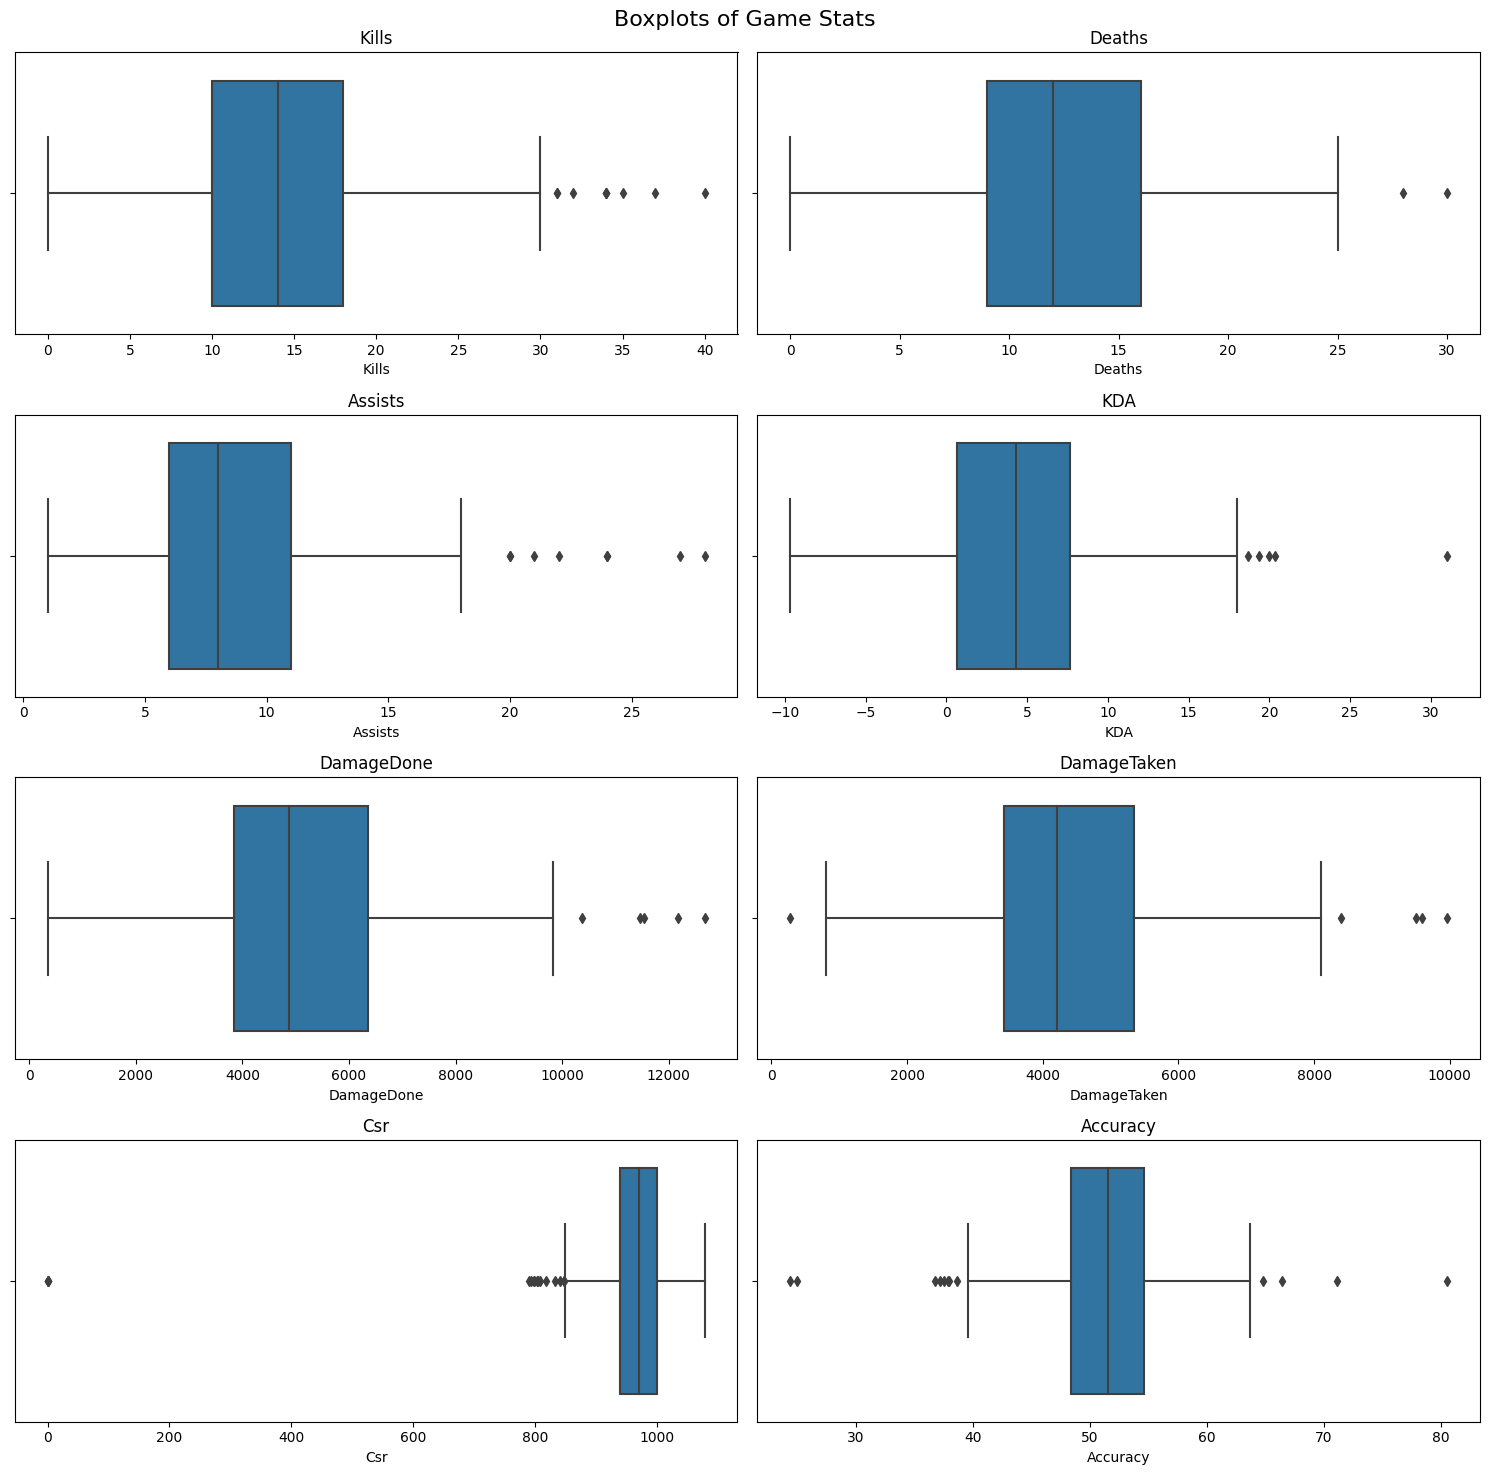

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [46]:
mod = 5

# dfmod = dfr.loc[dfr['Deaths'] < mod, 
#                 ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
#                 ].sort_values('DamageDone', ascending=False)

# Column Choice <>
# dfmod = dfr.loc[dfr['Deaths'] < mod]

# Last * Games
dfmod = dfr.tail(mod)

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")

Overall KD: 1.66
Accuracy: 51.37
Damage Ratio: 1.29
Win-Loss: 4-1
Max CSR: 890


In [47]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills"].sum() / dfr["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.13
Average Kills: 14.55
Average Deaths: 12.84
Average Assists: 8.42
Average Accuracy: 51.34
Average Damage Done: 5156
Average Damage Taken: 4421
Damage Ratio: 1.17
Win-Loss: 247-209
----------------------------
Wins
Overall KD: 1.27
Average Kills: 14.34
Average Deaths: 11.26
Average Assists: 8.55
Average Accuracy: 51.44
Average Damage Done: 4976
Average Damage Taken: 4060
Damage Ratio: 1.23
Wins: 247
----------------------------
Losses
Overall KD: 1.01
Average Kills: 14.79
Average Deaths: 14.71
Average Assists: 8.27
Average Accuracy: 51.22
Average Damage Done: 5368
Average Damage Taken: 4847
Damage Ratio: 1.11
Losses: 209


In [48]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

# Print the scorigami list
# print("Scorigami List:")
# print(scorigami_list)
# print(dfGami.tail())

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

     Kills  Deaths  Assists Scorigami
80      40      17       24  40-17-24
310     37      28       17  37-28-17
338     35      25       18  35-25-18
103     34      23        7   34-23-7
392     34      21       15  34-21-15


In [49]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >1 SS: " ,gamiPiv[gamiPiv.values>1].count())
print(gamiPiv[gamiPiv.values>1].sort_index(ascending=True).sort_values(ascending=False))


Records with >1 SS:  28
Scorigami
7-12-7      3
6-11-8      3
10-7-1      2
10-7-5      2
8-11-5      2
7-8-7       2
7-12-4      2
7-11-6      2
24-19-6     2
21-18-9     2
20-12-6     2
19-18-10    2
17-17-3     2
17-14-5     2
16-11-8     2
15-8-7      2
15-13-8     2
15-11-8     2
15-10-14    2
14-14-7     2
14-11-8     2
14-10-11    2
13-14-10    2
13-11-9     2
12-10-6     2
11-8-7      2
11-12-7     2
9-11-3      2
dtype: int64


In [50]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

,LengthMinutes,Count,LengthHours,Length%,Count%,TimeMultiple
Category,,,,,,
Slayer,939.23,109,15.65,19.80,23.90,-4.10
Strongholds,889.45,75,14.82,18.75,16.45,2.30
Oddball,810.15,68,13.50,17.08,14.91,2.17
King of the Hill,669.82,62,11.16,14.12,13.60,0.52
Extraction,611.85,70,10.20,12.90,15.35,-2.45
CTF 3 Captures,581.20,53,9.69,12.25,11.62,0.63
CTF,240.87,19,4.01,5.08,4.17,0.91


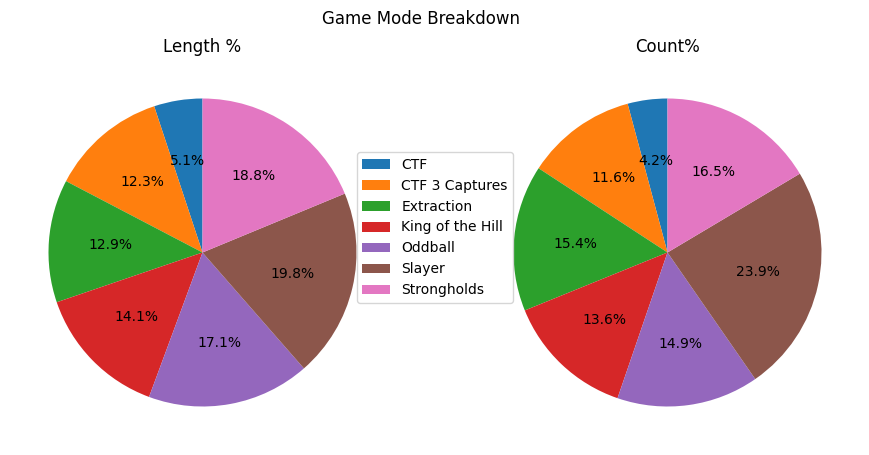

In [51]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()

fig, ax = plt.subplots(1, 2, figsize=(11, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle('Game Mode Breakdown')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count%')
fig.legend(labels, loc="center")

plt.show()

In [52]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      35         7.47     0.40    7.68     9.45
King of the Hill Recharge      29         5.65     0.59    6.36     7.15
Oddball          Streets       28         5.64     0.54    6.14     7.13
Slayer           Aquarius      35         4.98     0.60    7.68     6.30
                 Solitude      33         4.86     0.58    7.24     6.15
Extraction       Streets       33         4.74     0.61    7.24     6.00
Oddball          Recharge      21         4.13     0.52    4.61     5.22
CTF              Aquarius      19         4.01     0.37    4.17     5.07
Strongholds      Recharge      21         3.94     0.43    4.61     4.98
Oddball          Live Fire     19         3.74     0.63    4.17     4.73
Strongholds      Live Fire     19         3.42     0.58    4.17     4.33
CTF 3 Captures   Argyle        18         3.40     0.50    3.95     4.30
                 Empyrean      18         3.35     0.39    3.95     4.24
King of the Hill Live Fire     20         3.04     0.75    4.39     3.85
CTF 3 Captures   Forbidden     17         2.94     0.65    3.73     3.72
Extraction       Recharge      18         2.76     0.61    3.95     3.49
                 Live Fire     19         2.70     0.42    4.17     3.42
King of the Hill Solitude      13         2.48     0.46    2.85     3.14
Slayer           Live Fire     15         2.20     0.40    3.29     2.78
                 Streets       16         2.09     0.75    3.51     2.64
                 Recharge      10         1.52     0.60    2.19     1.92

In [53]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Accuracy'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Accuracy', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
Extraction       Live Fire     19    230     216      125       82363   
                 Streets       33    453     351      253      147191   
Oddball          Streets       28    492     444      305      172665   
King of the Hill Live Fire     20    286     261      134       93315   
Strongholds      Solitude      35    679     585      403      231173   
                 Live Fire     19    296     238      122       99698   
CTF 3 Captures   Forbidden     17    239     183      115       84417   
King of the Hill Solitude      13    255     189      125       79048   
Oddball          Live Fire     19    295     293      208      112113   
Extraction       Recharge      18    230     193      143       80159   
CTF              Aquarius      19    371     290      183      125998   
Slayer           Aquarius      35    375     350      224      144316   
CTF 3 Captures   Empyrean      18    263     249      149       92507   
King of the Hill Recharge      29    521     453      354      183517   
Slayer           Solitude      33    350     364      215      136766   
Oddball          Recharge      21    344     291      203      123821   
CTF 3 Captures   Argyle        18    256     220      119       90105   
Slayer           Live Fire     15    153     153       79       56576   
                 Streets       16    147     142      108       59038   
Strongholds      Recharge      21    306     298      200      114450   
Slayer           Recharge      10     92      93       73       41703   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
Extraction       Live Fire        72351     0.42         162.17     55.24   
                 Streets         118482     0.61         284.25     54.27   
Oddball          Streets         149097     0.54         338.37     53.76   
King of the Hill Live Fire        84979     0.75         182.30     53.75   
Strongholds      Solitude        195907     0.40         448.38     52.81   
                 Live Fire        87930     0.58         204.93     52.45   
CTF 3 Captures   Forbidden        65949     0.65         176.37     52.33   
King of the Hill Solitude         65007     0.46         148.55     51.63   
Oddball          Live Fire        94966     0.63         224.22     51.57   
Extraction       Recharge         66596     0.61         165.43     51.43   
CTF              Aquarius         99608     0.37         240.87     51.32   
Slayer           Aquarius        127422     0.60         299.02     50.85   
CTF 3 Captures   Empyrean         82939     0.39         200.88     50.75   
King of the Hill Recharge        153794     0.59         338.97     50.66   
Slayer           Solitude        127594     0.58         291.73     50.01   
Oddball          Recharge        103897     0.52         247.57     49.20   
CTF 3 Captures   Argyle           76644     0.50         203.95     48.98   
Slayer           Live Fire        54644     0.40         131.95     48.52   
                 Streets          51569     0.75         125.57     48.14   
Strongholds      Recharge         99050     0.43         236.13     48.14   
Slayer           Recharge         37402     0.60          90.97     47.45   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
Extraction       Live Fire  1.06         1.14    381.31       46.35   
                 Streets    1.29         1.24    419.35       81.79   
Oddball          Streets    1.11         1.16    388.89       53.08   
King of the Hill Live Fire  1.10         1.10    357.53       31.94   
Strongholds      Solitude   1.16         1.18    395.17       60.28   
                 Live Fire  1.24         1.13    418.90       49.45   
CTF 3 Ca

In [54]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
King of the Hill,62,1062,903,613,355880,303780,0.61,1.18,1.17,394.11,57.70,0.68
Slayer,109,1117,1102,699,438399,398631,0.59,1.01,1.10,397.82,36.09,0.63
Oddball,68,1131,1028,716,408599,347960,0.56,1.10,1.17,397.47,58.99,0.70
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
CTF 3 Captures,53,758,652,383,267029,225532,0.51,1.16,1.18,409.55,63.65,0.59
Strongholds,75,1281,1121,725,445321,382887,0.45,1.14,1.16,397.25,55.69,0.65
CTF,19,371,290,183,125998,99608,0.37,1.28,1.26,434.48,91.00,0.63


In [55]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,99,1493,1328,973,543650,460739,0.55,1.12,1.18,409.38,62.43,0.73
Streets,77,1092,937,666,378894,319148,0.61,1.17,1.19,404.37,63.76,0.71
Solitude,81,1284,1138,743,446987,388508,0.48,1.13,1.15,392.78,51.39,0.65
Aquarius,54,746,640,407,270314,227030,0.52,1.17,1.19,422.37,67.63,0.64
Forbidden,17,239,183,115,84417,65949,0.65,1.31,1.28,461.30,100.92,0.63
Empyrean,18,263,249,149,92507,82939,0.39,1.06,1.12,371.51,38.43,0.60
Live Fire,92,1260,1161,668,444065,394870,0.57,1.09,1.12,382.48,42.37,0.58
Argyle,18,256,220,119,90105,76644,0.50,1.16,1.18,409.57,61.19,0.54


In [56]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 9.285921291972045s
